In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import tensorflow as tf

from mlxtend.data import loadlocal_mnist
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
#from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import random as rd
import numpy as np
import functools

from sklearn import metrics

%matplotlib inline

In [2]:
def load_data(dataset_name) :
    path_dir_0 = "./Dataset/"
    if dataset_name == "MNIST" :
        path_dir = os.path.join(path_dir_0, "MNIST")
        x_train_path = os.path.join(path_dir,"train-images.idx3-ubyte")
        y_train_path = os.path.join(path_dir,"train-labels.idx1-ubyte")

        x_test_path = os.path.join(path_dir,"t10k-images.idx3-ubyte")
        y_test_path = os.path.join(path_dir,"t10k-labels.idx1-ubyte")
        x_train, y_train = loadlocal_mnist(x_train_path, y_train_path)

        x_test, y_test = loadlocal_mnist(x_test_path, y_test_path)
        
        x_test = (x_test/255).reshape(-1,28,28)
        x_train = (x_train/255).reshape(-1,28,28)
        
        
        
    return x_train, x_test

x_train, x_test = load_data("MNIST") 

In [3]:
print(x_train.shape)

print(x_test.shape)


(60000, 28, 28)
(10000, 28, 28)


In [4]:
dims_data = x_train[0].shape
dims_data

(28, 28)

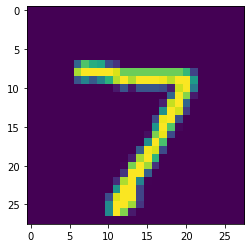

In [5]:
imgplot = plt.imshow(x_test[0])


In [6]:
latent_dim = 25


dim_dense_decoder = functools.reduce(lambda a,b : a*b, dims_data)
class Autoencoder_base(Model):
    def __init__(self, latent_dim):
        super(Autoencoder_base, self).__init__()
        self.latent_dim = latent_dim   
        
        self.encoder = tf.keras.Sequential([layers.Flatten(), layers.Dense(latent_dim, activation='relu'),])
        
        self.decoder = tf.keras.Sequential([layers.Dense(dims_data[0]*dims_data[1], activation='sigmoid'),layers.Reshape(dims_data)])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    
class Autoencoder_W_CNN(Model):
    def __init__(self, latent_dim):
        super(Autoencoder_W_CNN, self).__init__()
        self.latent_dim = latent_dim   
        
        self.encoder = tf.keras.Sequential([layers.Reshape((dims_data[0], dims_data[1], 1)),
                                            
                                            layers.Conv2D(32, (3, 3), activation='relu'),
                                            layers.MaxPooling2D((2, 2)),
                                            layers.Flatten(),
                                            
                                            layers.Dense(latent_dim, activation='relu') ])
        
        size_2D_latent_space = int(latent_dim**0.5)


        self.decoder = tf.keras.Sequential([
                                            
                                            layers.Reshape((size_2D_latent_space,-1,1)),
            
                                            layers.Conv2D(32, (3, 3), activation='relu'),
                                            layers.MaxPooling2D((2, 2)),
                                            layers.Flatten(),
            
                                            layers.Dense(dim_dense_decoder, activation='sigmoid'),
                                            layers.Reshape(dims_data)
                                            ])


    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder_W_CNN(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.build((None, 28, 28))
autoencoder.summary()

Model: "autoencoder_w_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 25)                135545    
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            26192     
                                                                 
Total params: 161,737
Trainable params: 161,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = autoencoder.fit(x_train, x_train,
                epochs=15,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/15
1875/1875 [==============================] - 160s 85ms/step - loss: 0.0446 - val_loss: 0.0322
Epoch 2/15
1672/1875 [=========================>....] - ETA: 16s - loss: 0.0311

In [ ]:
fig =plt.figure()
plt.plot(hist.history['loss'], color ='teal', label ='train_loss')
fig.suptitle('Loss', fontsize =20)
plt.legend(loc ="upper left")
plt.show()

# Test

In [ ]:
id_current = 15

In [ ]:
imgplot = plt.imshow(x_test[id_current])

In [ ]:
encoded_imgs_test = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs_test).numpy()

imgplot = plt.imshow(decoded_imgs[id_current])

In [ ]:
df_tmp = pd.DataFrame(encoded_imgs_test)
df_tmp.boxplot()

# Noise

In [ ]:
def random_from_distrib(distrib) :
    #distrib = distrib.reshape(-1)

    n, size = distrib.shape
    
    
    out = np.array([rd.choice(distrib[:,j]) for j in range(size)])
    
    return out

In [ ]:

def get_generated_images(model, distrib, count = 1) :
    
    noise_list = []
    for i in range(count) : 
        
        noise_list.append(random_from_distrib(distrib) ) 
        
    noise_array = np.array(noise_list)
    noise_decoded = model.decoder(noise_array).numpy()
    
    return noise_decoded




In [ ]:
generated_images = get_generated_images(autoencoder,encoded_imgs_test, count = 15)
fig, ax = plt.subplots(3, 5, figsize=(14,8))
fig.tight_layout()

#create subplots
for i in range(5) :
    for j in range(3) :
        ax[j, i].imshow(generated_images[j*5+i])
